# QUANTUM VARIATIONAL CLASSIFIER

## Iris classification

In this notebook we are going to classify some data points of the Iris Dataset in two different classes. Let's build a variational quantum circuit for it!

#### Imports

In [75]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

### 1. Data

#### 1.1 Preprocessing data

In [76]:
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
print(data[45:55])
print(f"\nData shape: {data.shape}")

[[ 0.25  0.5   0.2   0.1  -1.  ]
 [ 0.4   0.9   0.3   0.05 -1.  ]
 [ 0.15  0.6   0.2   0.05 -1.  ]
 [ 0.5   0.85  0.25  0.05 -1.  ]
 [ 0.35  0.65  0.2   0.05 -1.  ]
 [ 1.35  0.6   1.85  0.65  1.  ]
 [ 1.05  0.6   1.75  0.7   1.  ]
 [ 1.3   0.55  1.95  0.7   1.  ]
 [ 0.6   0.15  1.5   0.6   1.  ]
 [ 1.1   0.4   1.8   0.7   1.  ]]

Data shape: (100, 5)


Here we load the data and show some entries to get an idea of the dataset. As we can see, it's seems that the first 4 columns correspond to the features and the last one represents the class identifier. It's also interesting to note that the first fifty entries belong to one class and the other fifty to the second.

In [77]:
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

First X sample (original)  : [0.4  0.75]


In [78]:
# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

First X sample (padded)    : [0.4  0.75 0.1  0.1 ]


Here we have to increase the size of the input data adding two 'latent dimensions'. This is due to we are going to construct a 2-qubit circuit and we have to match the size of the state vector in the quantum device.

2² = 4

In [79]:
# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")
print("X shape:", X_norm.shape)

First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
X shape: (100, 4)


In [80]:
Y = data[:, -1]
print(f"First Y sample: {Y[0]}")
print("Y shape:", Y.shape)

First Y sample: -1.0
Y shape: (100,)


#### 1.2 Transforming data

Now we have to create a function that transform previous data in a appropiate form that allow us encode it into the quantum circuit.

In [81]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [82]:
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


And now, we have obtained the kind of data that we are going to encode into the circuit.

#### 1.3 Training and validation data

Due to we want that our model learns to predict correctly unseen data, we have to split our dataset into training and validation data. In this case, the chosen proportion is 75% test and 25% validation.

In [83]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data)) # Random sort of the data
feats_train = features[index[:num_train]] # Randomly select 75% of the data for training
Y_train = Y[index[:num_train]] 
feats_val = features[index[num_train:]] # Randomly select 25% of the data for validation
Y_val = Y[index[num_train:]]

print(feats_train.shape)
print(Y_train.shape)
print(feats_val.shape)
print(Y_val.shape)

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

(75, 5)
(75,)
(25, 5)
(25,)


### 2. Circuit

The circuit is coded according to the scheme in [Möttönen, et al.
(2004)](https://arxiv.org/abs/quant-ph/0407010), or---as presented for
positive vectors only---in [Schuld and Petruccione
(2018)](https://link.springer.com/book/10.1007/978-3-319-96424-9). We
also decomposed controlled Y-axis rotations into more basic gates,
following [Nielsen and Chuang
(2010)](http://www.michaelnielsen.org/qcqi/).

Create a quantum device that will run our circuits

In [84]:
dev = qml.device("default.qubit")

#### 2.1 Encoding Data

In [85]:
def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Let’s test if this routine actually works.

In [86]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


The method computed the correct angles to prepare the desired state because the sum of the squares of all values in the amplitude vector is equal to one.

#### 2.2 Building the circuit 

Variational circuits are composed by differents layers of gates where the data is encoded and the params are trained. The params of the layers are called 'weights'.

Our circuit layer will use two qubits and consists of an arbitrary rotation on each qubit, as well as a CNOT gate that entangles both qubits.

In [87]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

In [88]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [89]:
# Adding a classical bias parameter
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

### 3. Optimization

#### 3.1 Cost and accuracy functions

Cost function is a very important component in machine learning and it guides the optimization process to improve the model. There are many differents examples of cost functions but we choose the standard square loss. It measures the average squared difference between the actual and predicted values and penalizes larger errors more significantly due to squaring.

In [90]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [91]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

To monitor how many inputs the current classifier predicted correctly, we also define the accuracy, or the proportion of predictions that agree with a set of target labels.

In [92]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

#### 3.2 Initial parameters

In [93]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Initial weights:\n", weights_init)
print("\nInitial bias:", bias_init)

Initial weights:
 [[[ 0.00066517  0.00302472 -0.00634322]
  [-0.00362741 -0.0067246  -0.00359553]]

 [[-0.00813146 -0.01726283  0.00177426]
  [-0.00401781 -0.01630198  0.00462782]]

 [[-0.00907298  0.00051945  0.00729091]
  [ 0.00128983  0.01139401 -0.01234826]]

 [[ 0.00402342 -0.0068481  -0.00870797]
  [-0.0057885  -0.00311553  0.00056165]]

 [[-0.0116515   0.00900826  0.00465662]
  [-0.01536244  0.01488252  0.01895889]]

 [[ 0.0117878  -0.00179925 -0.01070753]
  [ 0.01054452 -0.00403177  0.01222445]]]

Initial bias: 0.0


Here is important to remark that weights are divided by 6 sub-matrix corresponding to 6 layers of our model. Besides that, each layer contains 2 qubits that can encodes 4 points each one. In this case, the bias is this fourth point.

#### 3.3 Optimizing

In [94]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5 # Size of the batch for each optimization step.

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,)) # Select a random batch of data for training
    feats_train_batch = feats_train[batch_index] 
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 5 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     5 | Cost: 1.0311557 | Acc train: 0.4666667 | Acc validation: 0.5600000
Iter:    10 | Cost: 0.9553988 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    15 | Cost: 1.0671028 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8905087 | Acc train: 0.5733333 | Acc validation: 0.7600000
Iter:    25 | Cost: 0.7928809 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    30 | Cost: 0.6441892 | Acc train: 0.7200000 | Acc validation: 0.7200000
Iter:    35 | Cost: 0.4206965 | Acc train: 0.9200000 | Acc validation: 0.9600000
Iter:    40 | Cost: 0.3059319 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    45 | Cost: 0.2536889 | Acc train: 1.0000000 | Acc validation: 1.0000000
Iter:    50 | Cost: 0.2441273 | Acc train: 0.9866667 | Acc validation: 1.0000000
Iter:    55 | Cost: 0.2303846 | Acc train: 1.0000000 | Acc validation: 1.0000000
Iter:    60 | Cost: 0.2241924 | Acc train: 1.0000000 | Acc validation: 1.0000000


With only 35/40 steps, the model manages to get closer to 100% accuracy in both seen and unseen data.

#### 3.4 Plotting results

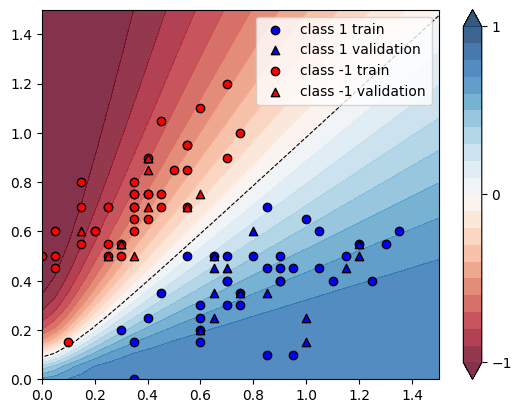

In [95]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

### 4. Conclusion

We can see that the model have learnt properly to classify differents data-features in the two classes of this experiment about the Iris dataset.